In [100]:
from bioformers.datasets.ArrowDataset import ArrowDataset
from bioformers.datasets import dataset_utils
from bioformers.utilize.Bert import BertSeqClassification
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import os
import numpy
import warnings 

from transformers import BertModel, BertTokenizer
import re

from datasets import load_dataset
from datasets import Dataset
from datasets import load_from_disk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch

from abc import ABC
import pytorch_lightning as pl
from transformers import BertForTokenClassification, BertConfig, Adafactor, AdamW
from sklearn.metrics import balanced_accuracy_score
import torch.nn.functional as F


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["MKL_THREADING_LAYER"] = "GNU"
os.environ["TOKENIZERS_PARALLELISM"] = "true"


num_cpu = 16
max_length = 512
lr = '1e-7.473'
num_labels = 430
max_epch = 21
gpu = '4'
min_lr = float(1e-5)
max_lr = float(0.005)

encoded_csv = f"/mnt/storage/grid/home/eric/hmm2bert/pullin_parsed_data/encoded_parsed_pullin>100_pure.csv"

saved_strat_train = f"/mnt/storage/grid/home/eric/hmm2bert/pullin_parsed_data/embedding_pullin_train>100_stratified.pt"
saved_strat_val = f"/mnt/storage/grid/home/eric/hmm2bert/pullin_parsed_data/embedding_pullin_val>100_stratified.pt"

In [105]:
class BertTokClassification(pl.LightningModule, ABC):
    def __init__(
            self,
            config: BertConfig = None,
            pretrained_dir: str = None,
            use_adafactor: bool = False,
            learning_rate=3e-5,
            **kwargs
    ):
        super().__init__()
        self.learning_rate = learning_rate
        self.use_adafactor = use_adafactor
        if pretrained_dir is None:
            self.bert = BertForTokenClassification(config, **kwargs)
        else:
            self.bert = BertForTokenClassification.from_pretrained(pretrained_dir, **kwargs)

    def forward(self, input_ids, attention_mask, labels):
        return self.bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        outputs = self(
            input_ids=input_ids.to(self.device),
            attention_mask=attention_mask.to(self.device),
            labels=labels.to(self.device)
        )
        loss = outputs.loss
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        outputs = self(
            input_ids=input_ids.to(self.device),
            attention_mask=attention_mask.to(self.device),
            labels=labels.to(self.device)
        )
        loss = outputs.loss
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

        def get_balanced_accuracy(labels, logits):
            y_pred = torch.max(logits, 1).indices
            score = balanced_accuracy_score(labels, y_pred)
            return score


        accuracy = get_balanced_accuracy(labels.cpu(), logits=outputs.logits.cpu())
        self.log(
            "accuracy",
            accuracy,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return {"val_loss": loss}

    def configure_optimizers(self):
        if self.use_adafactor:
            return Adafactor(
                self.parameters(),
                lr=self.learning_rate,
                eps=(1e-30, 1e-3),
                clip_threshold=1.0,
                decay_rate=-0.8,
                beta1=None,
                weight_decay=0.0,
                relative_step=False,
                scale_parameter=False,
                warmup_init=False)
        else:
            return AdamW(self.parameters(), lr=self.learning_rate)

    def save_pretrained(self, pretrained_dir):
        self.bert.save_pretrained(self, prtrained_dir)

    def predict_classes(self, input_ids, attention_mask, return_logits=False):
        output = self.bert(input_ids=input_ids.to(self.device), attention_mask=attention_mask)
        if return_logits:
            return output.logits
        else:
            probabilities = F.softmax(output.logits)
            predictions = torch.argmax(probabilities)
            return {"probabilities": probabilities, "predictions": predictions}

    def get_attention(self, input_ids, attention_mask, specific_attention_head: int = None):
        output = self.bert(inputs_ids=input_ids.to(self.device), attention_mask=attention_mask)
        if specific_attention_head is not None:
            last_layer = output.attentions[-1] #grabs the last layer
            all_last_attention_heads = [torch.max(this_input[specific_attention_head], axis=0)[0].indices for this_input in last_layer]
            return all_last_attention_heads
        return output.attentions

In [106]:
#create dataset object
import torch

class TokenDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} #keys are input_ids, token_type_ids, attention_mask, labels, values are stored as a list of lists
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return (len(self.labels))
    


In [107]:
#################

In [160]:
class BertTokClassification1(pl.LightningModule, ABC):
    def __init__(
            self,
            config: BertConfig = None,
            pretrained_dir: str = None,
            use_adafactor: bool = False,
            learning_rate=3e-5,
            **kwargs
    ):
        super().__init__()
        self.learning_rate = learning_rate
        self.use_adafactor = use_adafactor
        if pretrained_dir is None:
            self.bert = BertForTokenClassification(config, **kwargs)
        else:
            self.bert = MultiOutputClassifier(BertForTokenClassification.from_pretrained(pretrained_dir, **kwargs))
            self.bertParam = BertForTokenClassification.from_pretrained(pretrained_dir, **kwargs)

    def forward(self, input_ids, attention_mask, labels):
        return self.bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        outputs = self(
            input_ids=input_ids.to(self.device),
            attention_mask=attention_mask.to(self.device),
            labels=labels.to(self.device)
        )
        loss = outputs.loss
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        outputs = self(
            input_ids=input_ids.to(self.device),
            attention_mask=attention_mask.to(self.device),
            labels=labels.to(self.device)
        )
        loss = outputs.loss
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

        def get_balanced_accuracy(labels, logits):
            y_pred = torch.max(logits, 1).indices
            score = balanced_accuracy_score(labels, y_pred)
            return score


        accuracy = get_balanced_accuracy(labels.cpu(), logits=outputs.logits.cpu())
        self.log(
            "accuracy",
            accuracy,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return {"val_loss": loss}
    def print_param(self):
        return print(list(self.bertParam.parameters()))
    
    def configure_optimizers(self):
        if self.use_adafactor:
            return Adafactor(
                self.bertParam.parameters(),
                lr=self.learning_rate,
                eps=(1e-30, 1e-3),
                clip_threshold=1.0,
                decay_rate=-0.8,
                beta1=None,
                weight_decay=0.0,
                relative_step=False,
                scale_parameter=False,
                warmup_init=False)
        else:
            return AdamW(self.parameters(), lr=self.learning_rate)

    def save_pretrained(self, pretrained_dir):
        self.bert.save_pretrained(self, prtrained_dir)

    def predict_classes(self, input_ids, attention_mask, return_logits=False):
        output = self.bert(input_ids=input_ids.to(self.device), attention_mask=attention_mask)
        if return_logits:
            return output.logits
        else:
            probabilities = F.softmax(output.logits)
            predictions = torch.argmax(probabilities)
            return {"probabilities": probabilities, "predictions": predictions}

    def get_attention(self, input_ids, attention_mask, specific_attention_head: int = None):
        output = self.bert(inputs_ids=input_ids.to(self.device), attention_mask=attention_mask)
        if specific_attention_head is not None:
            last_layer = output.attentions[-1] #grabs the last layer
            all_last_attention_heads = [torch.max(this_input[specific_attention_head], axis=0)[0].indices for this_input in last_layer]
            return all_last_attention_heads
        return output.attentions

In [137]:
from sklearn.multioutput import MultiOutputClassifier

class MultiOutputClass(BertTokClassification1):
    pass


In [71]:
bsc = BertTokClassification(pretrained_dir='Rostlab/prot_bert', use_adafactor=True, num_labels=num_labels)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the

In [90]:
print(list(bsc.parameters()))

[Parameter containing:
tensor([[-0.1256,  0.0491,  0.0666,  ..., -0.0410,  0.0444, -0.0051],
        [-0.0649,  0.0257,  0.0945,  ..., -0.0332, -0.0319,  0.0591],
        [ 0.0592, -0.0364,  0.0806,  ..., -0.0226,  0.0270,  0.0130],
        ...,
        [ 0.0454, -0.0350,  0.0715,  ..., -0.0282,  0.0803,  0.0745],
        [-0.0093, -0.0082,  0.0446,  ..., -0.0113,  0.0279,  0.1097],
        [ 0.0531, -0.0205,  0.0603,  ..., -0.0308,  0.0926,  0.0463]],
       requires_grad=True), Parameter containing:
tensor([[-4.9734e-02, -1.0384e-01, -2.2914e-01,  ...,  8.9333e-02,
          1.4988e-01,  1.6117e-01],
        [-1.8311e-02,  9.7758e-02, -2.3101e-01,  ...,  1.0119e-01,
         -6.0341e-02,  4.2694e-02],
        [-7.3091e-02, -3.3575e-03, -2.2049e-01,  ...,  1.6153e-01,
         -1.0128e-01, -9.3914e-02],
        ...,
        [-6.1858e-04,  1.0358e-03, -1.5056e-03,  ..., -8.4570e-04,
         -5.8910e-04,  4.6343e-04],
        [-2.1044e-03, -9.5645e-04, -5.9256e-04,  ...,  7.9082e-04,
 

In [133]:
new = MultiOutputClassifier(bsc)

In [136]:
print(list(new.get_params(deep=True)))

['estimator', 'n_jobs']


In [158]:
new1 = BertTokClassification1(pretrained_dir="Rostlab/prot_bert", use_adafactor=True, learning_rate=lr, num_labels=num_labels)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the

In [159]:
print(new1.print_param())

[Parameter containing:
tensor([[-0.1256,  0.0491,  0.0666,  ..., -0.0410,  0.0444, -0.0051],
        [-0.0649,  0.0257,  0.0945,  ..., -0.0332, -0.0319,  0.0591],
        [ 0.0592, -0.0364,  0.0806,  ..., -0.0226,  0.0270,  0.0130],
        ...,
        [ 0.0454, -0.0350,  0.0715,  ..., -0.0282,  0.0803,  0.0745],
        [-0.0093, -0.0082,  0.0446,  ..., -0.0113,  0.0279,  0.1097],
        [ 0.0531, -0.0205,  0.0603,  ..., -0.0308,  0.0926,  0.0463]],
       requires_grad=True), Parameter containing:
tensor([[-4.9734e-02, -1.0384e-01, -2.2914e-01,  ...,  8.9333e-02,
          1.4988e-01,  1.6117e-01],
        [-1.8311e-02,  9.7758e-02, -2.3101e-01,  ...,  1.0119e-01,
         -6.0341e-02,  4.2694e-02],
        [-7.3091e-02, -3.3575e-03, -2.2049e-01,  ...,  1.6153e-01,
         -1.0128e-01, -9.3914e-02],
        ...,
        [-6.1858e-04,  1.0358e-03, -1.5056e-03,  ..., -8.4570e-04,
         -5.8910e-04,  4.6343e-04],
        [-2.1044e-03, -9.5645e-04, -5.9256e-04,  ...,  7.9082e-04,
 

In [ ]:
##################

In [4]:
# load tokenizer and wandb logger

wandb_logger = WandbLogger(name=f"classify_domain-{lr}", project="hmm_reBERT")

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
#model = BertModel.from_pretrained("Rostlab/prot_bert")



# ===========================================================

In [5]:
encoded_test = torch.load(saved_strat_val)

In [6]:
encoded_train = torch.load(saved_strat_train)

In [7]:
print(len(encoded_test[0]["input_ids"]))
print(len(encoded_test[0]["labels"]))

512
512


In [8]:
#load train and test tensors and instantiate pytorch lightning wrapper for the huggingface model with the base pretrained protbert model

#encoded_train = torch.load(saved_strat_train)
#encoded_test = torch.load(saved_strat_val)

#bsc = BertSeqClassification(pretrained_dir="Rostlab/prot_bert", use_adafactor=True, num_labels=num_labels)
#bsc = BertForTokenClassification.from_pretrained('Rostlab/prot_bert', num_labels=num_labels)

bsc = BertTokClassification(pretrained_dir="Rostlab/prot_bert", use_adafactor=True, num_labels=num_labels)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the

In [9]:
# setup data collator, trainer, and dataloader for train and test dataset

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    max_epochs=max_epch,
    gpus=gpu,
    auto_lr_find=False,
    logger=wandb_logger
)

warnings.filterwarnings("ignore")

train_dl = DataLoader(encoded_train, batch_size=4, num_workers=num_cpu, collate_fn=data_collator, shuffle=True)
eval_dl = DataLoader(encoded_test, batch_size=4, num_workers=num_cpu, collate_fn=data_collator, shuffle=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [10]:
lr_finder = trainer.tuner.lr_find(bsc, train_dataloader=train_dl, min_lr=min_lr, max_lr=max_lr, num_training=100, mode='exponential', early_stop_threshold=4)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type                       | Params
----------------------------------------------------
0 | bert | BertForTokenClassification | 419 M 
----------------------------------------------------
419 M     Trainable params
0         Non-trainable params
419 M     Total params
1,677.289 Total estimated model params size (MB)


Restored states from the checkpoint file at /mnt/storage/grid/home/eric/hmm2bert/work/pullin_db/lr_find_temp_model.ckpt


In [11]:
lr_finder.results

{'lr': [1e-05,
  1.1323466513027154e-05,
  1.2049502056209654e-05,
  1.2822089387164734e-05,
  1.3644213303214186e-05,
  1.451904998026007e-05,
  1.5449979243554545e-05,
  1.6440597625244246e-05,
  1.7494732259135444e-05,
  1.8616455666360695e-05,
  1.9810101489069612e-05,
  2.1080281232928992e-05,
  2.2431902083114908e-05,
  2.387018586262662e-05,
  2.540068920616557e-05,
  2.702932502751867e-05,
  2.876238536338261e-05,
  3.060656568188344e-05,
  3.256899074970453e-05,
  3.4657242157757324e-05,
  3.6879387611737036e-05,
  3.9244012100723797e-05,
  4.176025106424528e-05,
  4.443782568593783e-05,
  4.728708045015879e-05,
  5.0319023106645494e-05,
  5.3545367197619414e-05,
  5.6978577311633986e-05,
  6.0631917238998584e-05,
  6.45195012148216e-05,
  6.865634844764343e-05,
  7.305844114432471e-05,
  7.774278625536142e-05,
  8.272748117917262e-05,
  8.803178367920126e-05,
  9.36761862839445e-05,
  9.968249545734857e-05,
  0.00010607391584543393,
  0.00011287513992462681,
  0.0001201124433

In [ ]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))

# =====LR Finder=====

suggested lr: 0.0005679766774033139
min lr: 1e-05
max lr: 0.005


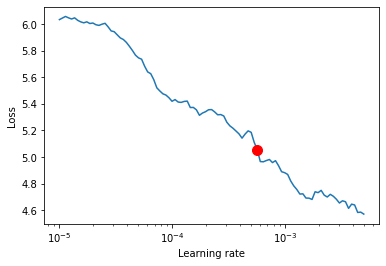

In [12]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))

suggested lr: 0.00252960321170294
min lr: 1e-06
max lr: 0.005


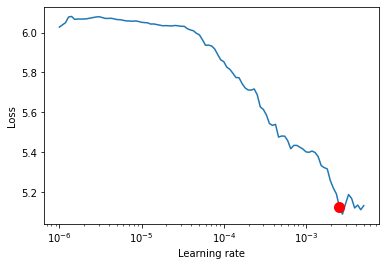

In [12]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))

suggested lr: 0.00032362503024629713
min lr: 1e-06
max lr: 0.0005


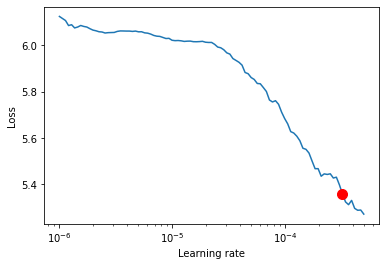

In [12]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))

suggested lr: 0.0003792887875145918
min lr: 5e-06
max lr: 0.0005


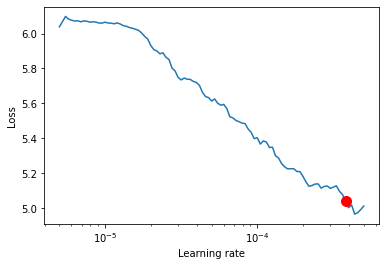

In [12]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))

suggested lr: 0.00011994164595097455
min lr: 5e-06
max lr: 0.005


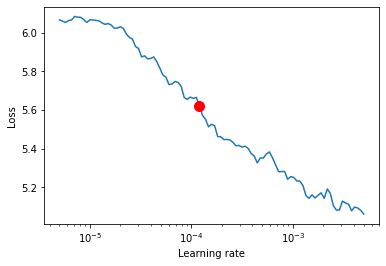

In [12]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))

suggested lr: 0.002133403503223242
min lr: 1e-06
max lr: 0.005


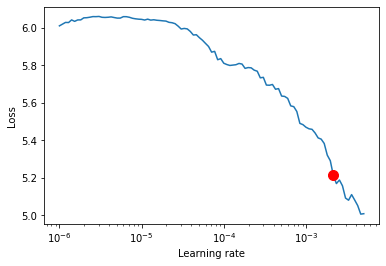

In [12]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))

suggested lr: 0.00015400924857617555
min lr: 1e-05
max lr: 0.005


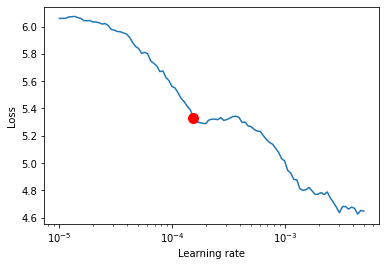

In [12]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))

suggested lr: 0.002275264045877198
min lr: 1e-08
max lr: 0.005


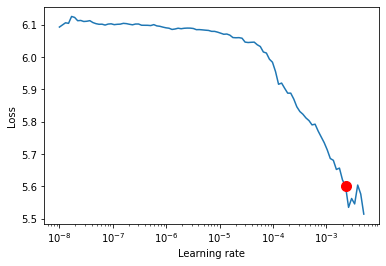

In [12]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))

suggested lr: 0.0020607319480188614
min lr: 1e-10
max lr: 0.005


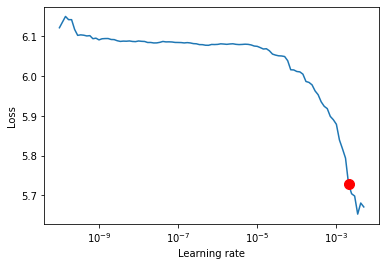

In [14]:
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) #0.0001 max, 1e-13 min, lowest 3.1084745275846952
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))